# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса по недвижимости — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### 1. Изучите общую информацию. 

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

In [2]:
def info(df):
    indx=[]
    col_info=[]
    format_str = "{count} non-null {dtype}"
    counts = df.count()
    dtypes = df.dtypes
    for i, col in enumerate(df.columns):
        indx.append(col)
        col_info.append(format_str.format(count=counts.iloc[i], dtype=dtypes.iloc[i]))
    return indx, col_info

indx, col_info = info(df)
df_info = pd.DataFrame(data=col_info, index=indx, columns=['info'])
df_info['isna'] = df.isna().sum()
df_info

,info,isna
total_images,23699 non-null int64,0
last_price,23699 non-null float64,0
total_area,23699 non-null float64,0
first_day_exposition,23699 non-null object,0
rooms,23699 non-null int64,0
ceiling_height,14504 non-null float64,9195
floors_total,23613 non-null float64,86
living_area,21796 non-null float64,1903
floor,23699 non-null int64,0
is_apartment,2775 non-null object,20924


### Вывод

Файл данный содержит 23698 записей о квартирах.  
Типы некоторых полей не соответствует действительности.  
Поле `is_apartment` имеет тип object, а должно быть булев тип.  
В поле `first_day_exposition` приведены даты, поэтому его можно преобразовать в тип `date`.

### 2. Предобработка данных

In [3]:
df['first_day_exposition'].head()

0    2019-03-07T00:00:00
1    2018-12-04T00:00:00
2    2015-08-20T00:00:00
3    2015-07-24T00:00:00
4    2018-06-19T00:00:00
Name: first_day_exposition, dtype: object

Поскольку в поле `first_day_exposition` часы, минуты и секунды нулевые, то при преобразовании можно указать формат без этих данных: `format='%Y-%m-%d'`

In [4]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%d')
df['first_day_exposition'].describe()

count                   23699
unique                   1491
top       2018-02-01 00:00:00
freq                      368
first     2014-11-27 00:00:00
last      2019-05-03 00:00:00
Name: first_day_exposition, dtype: object

Далее проверим данные на пропуски.

In [5]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Рассмотрим по-порядку поля с пустыми значениями.  

#### Первое поле - `ceiling_height` - высота потолков (м).  

Если бы в данных были типы домов (хрущевка, сталинка и т.п.), то можно было бы сделать привязку к средним по разным типам домов. Но поскольку такой информации нет, то предлагаю заполнить либо средним значением, либо медианой.

In [6]:
df['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

В данных наблюдается очень большой разброс (очевидно есть выбросы), следовательно среднее значение не очень подходит для нашей цели. Берем медиану.

In [7]:
df['ceiling_height'].fillna(2.65, inplace=True)


#### floors_total — всего этажей в доме

Всего пропусков 86.

In [8]:
df['floors_total'].describe()

count    23613.000000
mean        10.673824
std          6.597173
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

Опять мы видим большой разброс и явные выбросы.  
Да и медиану не применить, т.к. может оказаться, что человек живет на 10 этаже, тогда как медиана всего лишь 9.  

В общем-то, этажность дома не так важна и можно оставить эти пропуски.  
Но мы поступим по другому. Поскольку этажей в доме не меньше, чем этаж проживания человека, то заполним эти поля этажом проживания. 

In [9]:
df['floors_total'] = df['floor'].where(df['floors_total'].isna(), df['floors_total'])

#### living_area — жилая площадь в квадратных метрах(м²)

Всего пропусков 1903.  
Статистические показатели, которые мы получаем методом `describe()`, в данном случае не помогут.  

Поскольку у нас в стране площади балконов не входят в общую площадь, то наличие балконов никак не поможет в нашей проблеме.  
Но в некоторых случаях у нас есть в наличии информация о площади кухни - из 1903 указано всего 439 шт.  
Т.к. жилая площадь, это общая площадь за вычетом площади кухни, санузлов и прихожей, то еще нужно найти недостающую информацию о площадях прихожих и санузлов.  
Мы можем вычислить средние таких площадей по существующей статистике. Но это нужно будет делать много вычислений...

Я думаю, что в нашем исследовании можно применить среднюю долю жилой площади от общей площади в зависимости от количества комнат в квартире.

Особняком стоят квартиры-студии и квартиры со свободной планировкой.

Рассмотрим следующую таблицу.

In [10]:
df.pivot_table(index='studio', columns='open_plan', values=['total_area'], aggfunc='count')

total_area      
open_plan      False True 
studio                    
False        23483.0  67.0
True           149.0   NaN

Таким образом, множество квартир-студий и квартир со свободной планировкой не пересекаются.  
Считаю уместным ввести некое поле `kind`, в котором будет отображаться тип квартиры: `studio, op, usual`. 

In [11]:
df['kind'] = df['studio'].apply(lambda x: 'studio' if x else 'usual')
df['kind'] = df.apply(lambda row: 'op' if row['open_plan'] else row['kind'], axis=1)
df['kind'].value_counts()

usual     23483
studio      149
op           67
Name: kind, dtype: int64

In [12]:
df.pivot_table(index='rooms', columns='kind', values='total_area', aggfunc='count', fill_value='')

kind,op,studio,usual
rooms,,,
0,59,138,
1,3,11,8033
2,1,,7939
3,2,,5812
4,1,,1179
5,1,,325
6,,,105
7,,,59
8,,,12


Как мы видим, квартиры с 0 комнатами - это квартиры-студии и квартиры со свободной планировкой (в общем-то, это тоже студия). Только в нескольких случаях им присвоили значение - 1 комнатная.  
Как мы знаем, студия - это по сути одно комнатная квартира, поэтому логично было бы всем таким квартирам поставить значение 1.  
Но, чтобы отделить эти квартиры от обычных одно комнатных квартир мы всем студиям поставим значение 0 комнат.  
Для этого введем новое поле `rooms_group`.
  

In [13]:
df['rooms_group'] = df['rooms'].where(~(df['studio'] == 1), 0)
df['rooms_group'] = df['rooms_group'].where(~((df['rooms'] == 1) & (df['open_plan'] == 1)), 0)
df.pivot_table(index='rooms_group', columns='kind', values='total_area', aggfunc='count', fill_value='')

kind,op,studio,usual
rooms_group,,,
0,62,149,
1,,,8033
2,1,,7939
3,2,,5812
4,1,,1179
5,1,,325
6,,,105
7,,,59
8,,,12


Теперь для всех типов квартир найдем средние значения общих площадей и жилых площадей, вычислим долю жилых площадей, которые и будем применять для заполнения пропусков.

In [14]:
pvt = df.pivot_table(index='rooms_group', values=['total_area', 'living_area'], aggfunc=['mean', 'count'])
pvt['part'] = pvt['mean']['living_area'] / pvt['mean']['total_area']
pvt

mean                   count                 part
            living_area  total_area living_area total_area          
rooms_group                                                         
0             18.922640   29.333270         197        211  0.645091
1             17.890174   37.657841        7374       8033  0.475072
2             31.736849   55.855089        7296       7940  0.568200
3             47.387941   77.764580        5366       5814  0.609377
4             66.983223  107.610763        1089       1180  0.622458
5            100.009247  161.474816         292        326  0.619349
6            130.983636  201.537619          99        105  0.649922
7            163.564151  265.325424          53         59  0.616466
8            168.683333  259.233333          12         12  0.650701
9            190.257143  305.975000           7          8  0.621806
10           165.566667  259.566667           3          3  0.637858
11           133.900000  188.900000           2          2  0.708841
12           409.700000  900.000000           1          1  0.455222
14           195.150000  304.200000           2          2  0.641519
15           409.000000  590.000000           1          1  0.693220
16           180.000000  270.000000           1          1  0.666667
19           264.500000  374.600000           1          1  0.706086

Честно говоря, статистика квартир с количеством комнат от 7 не внушает доверия - слишком маленькая выбока.  
На всякий случай посмотрим сколько комнатные квартиры присутствуют в данных без жилой площади.

In [15]:
print('Всего квартир с пропущенной жилой площадью:', df['living_area'].isna().sum())

df.query('living_area.isna()').pivot_table(index='rooms', values='total_area', aggfunc='count')

Всего квартир с пропущенной жилой площадью: 1903


,total_area
rooms,
0,14
1,659
2,644
3,448
4,91
5,34
6,6
7,6
9,1


Обнаружили, что квартиры с количеством комнат от 7 присутствуют среди тех, у кого нет жилой площади.  
Предлагаю свести все квартиры с количеством комнат от 7 шт. в одну группу "7".

In [16]:
df['rooms_group'] = df['rooms_group'].where(~(df['rooms'] >= 7), 7)
pvt = df.pivot_table(index='rooms_group', values=['total_area', 'living_area'], 
                     fill_value='', aggfunc=['mean', 'count'])
pvt['part'] = pvt['mean']['living_area'] / pvt['mean']['total_area']
pvt

mean                   count                 part
            living_area  total_area living_area total_area          
rooms_group                                                         
0             18.922640   29.333270         197        211  0.645091
1             17.890174   37.657841        7374       8033  0.475072
2             31.736849   55.855089        7296       7940  0.568200
3             47.387941   77.764580        5366       5814  0.609377
4             66.983223  107.610763        1089       1180  0.622458
5            100.009247  161.474816         292        326  0.619349
6            130.983636  201.537619          99        105  0.649922
7            174.010843  279.025556          83         90  0.623638

In [17]:
df['living_area'] = df['living_area'].fillna(0)

def fill_la(row):
    if row['living_area'] == 0:
        total_area = row['total_area']
        rooms = row['rooms_group']
        part = pvt.loc[rooms, 'part']
        return float(total_area * part)
    return row['living_area']

df['living_area'] = df.apply(fill_la, axis=1)
df['living_area'].isna().sum()

0

#### is_apartment — апартаменты (булев тип)

Всего пропусков 20924

С данным полем все достаточно просто - все, что не помечено как аппартамент, не является аппартаментом.  
Т.е. все пропуски просто заполняем значением `False`.

In [18]:
df['is_apartment'] = df['is_apartment'].fillna(False)
print(df['is_apartment'].dtype)
df['is_apartment'].value_counts()

bool


False    23649
True        50
Name: is_apartment, dtype: int64

#### kitchen_area — площадь кухни в квадратных метрах (м²)

Всего пропусков 2278.

Введем поле `kitchen_exist`.

In [19]:
df['kitchen_exist'] = df['kitchen_area'].apply(lambda x: True if x > 0 else False)
df['kitchen_exist'].value_counts()

True     21421
False     2278
Name: kitchen_exist, dtype: int64

Теперь посмотрим, у каких типов квартир отсутствуют площади кухонь.

In [20]:
df.pivot_table(index='kind', columns='kitchen_exist', values='total_area', aggfunc='count')

kitchen_exist,False,True
kind,,
op,67.0,NaN
studio,149.0,NaN
usual,2062.0,21421.0


У квартир-студий и квартир со свободной планировкой площадь кухонь вообще не указана! Вроде это логично - там комната совмещена с кухней. Заполним нулями.    

Также площадь кухонь не указана у 2062 обычных квартир. Что с этим делать - не совсем понятно.   

Но, в общем-то, сюда полностью подходят рассуждения, что мы делали для заполнения жилой площади. Сделаем также.

In [21]:
df['kitchen_area'] = df['kitchen_area'].fillna(0)

In [22]:
pvt2 = df.pivot_table(index='rooms_group', values=['total_area', 'kitchen_area'], aggfunc=['mean', 'count'])
pvt2['part'] = pvt2['mean']['kitchen_area'] / pvt2['mean']['total_area']
pvt2

mean                    count                 part
            kitchen_area  total_area kitchen_area total_area          
rooms_group                                                           
0               0.000000   29.333270          211        211  0.000000
1               8.575252   37.657841         8033       8033  0.227715
2               9.157588   55.855089         7940       7940  0.163953
3              10.464424   77.764580         5814       5814  0.134565
4              12.517644  107.610763         1180       1180  0.116323
5              16.057607  161.474816          326        326  0.099443
6              19.445048  201.537619          105        105  0.096483
7              21.467778  279.025556           90         90  0.076938

In [23]:
def fill_ka(row):
    if row['kitchen_area'] == 0 and row['kind'] == 'usual':
        total_area = row['total_area']
        rooms = row['rooms_group']
        part = pvt2.loc[rooms, 'part']
        return float(total_area * part)
    return row['kitchen_area']

df['kitchen_area'] = df.apply(fill_ka, axis=1)
df['kitchen_area'].isna().sum()

0

#### balcony — число балконов

Всего пропусков 11519.

Информация о наличии балконов очень важна для покупателей, поэтому, если продавец не указал такую информацию, значит балконы отсутствуют. Пропуски заполняем нулями.

In [24]:
df['balcony'] = df['balcony'].where(~df['balcony'].isna(), 0)
df['balcony'].isna().sum()

0

#### locality_name — название населённого пункта

Всего пропусков 49.

Название населенного пункта, в котором находится продаваемая квартира, это очень важный параметр, без которого покупатель никогда не купит квартиру.  

Заполнить эти пропуски не представляется возможным.  
В очень редких случаях можно вычислить аналогичный пункт по растоянию от аэропорта и центра города, но придется делать очень много действий и в нашем проекте это не нужно.  

Но удалять эти записи мы не будем, т.к. их можно использовать в некоторых анализах, где наименование не играет роли. Например, зависит ли цена от удаленности от центра и проч.  

Но, все-таки, некоторые действия мы сделать можем.  
Я заметил, что в наименованиии населенного часто встречается буква "ё", но есть те же самые населенные пункты, в которых вместо буквы "ё" написана буква "е". Поэтому они воспринимаются как разные населенные пункты.  
Заменим ё на е.

In [25]:
df['locname_norm'] = df['locality_name'].apply(lambda x: str(x).replace("ё", "е"))
df['locname_norm'].head()

0    Санкт-Петербург
1     поселок Шушары
2    Санкт-Петербург
3    Санкт-Петербург
4    Санкт-Петербург
Name: locname_norm, dtype: object

In [73]:
df['locname_norm'].unique().__len__()

331

In [27]:
(df.groupby('locname_norm')['locname_norm'].count()).sort_values()

locname_norm
коттеджный поселок Счастье        1
деревня Сижно                     1
деревня Снегиревка                1
деревня Старое Хинколово          1
деревня Терпилицы                 1
                              ...  
Пушкин                          369
Всеволожск                      398
поселок Шушары                  440
поселок Мурино                  556
Санкт-Петербург               15721
Name: locname_norm, Length: 331, dtype: int64

#### airports_nearest — расстояние до ближайшего аэропорта в метрах (м)

Всего пропусков 5542.

В этом поле тоже не все так просто.  
Можно было бы для каждого населенного пункта сделать среднее растояние от этого населенного пункта до аэропорта...   

Но почти у всех населенных пунктов, если это не Санкт-Петербург, очень редко указано растояние до аэропорта.  
Или указано в очень редких случаях.   

Давайте проверим, у каких населенных пунктов указаны растояния до аэропорта.

In [28]:
df_tmp = df.loc[:, ['locname_norm', 'airports_nearest']]
airport_means = df_tmp.pivot_table(index='locname_norm', aggfunc={'airports_nearest': ['mean', 'count']}).dropna()
print('Всего населенных пуктов, у которых указано расстояние до аэропорта: ', len(airport_means))
airport_means.columns = ['count', 'mean']
airport_means

Всего населенных пуктов, у которых указано расстояние до аэропорта:  28


,count,mean
locname_norm,,
nan,41,24572.341463
Зеленогорск,24,73300.250000
Колпино,337,26375.863501
Красное Село,176,26595.579545
Кронштадт,95,67469.263158
Ломоносов,132,48308.280303
Павловск,38,21053.342105
Петергоф,201,40184.676617
Пушкин,369,16447.869919


Рассмотрим статистические показатели.

In [29]:
airport_means = airport_means.query('locname_norm != "nan" ')

describes = pd.DataFrame(columns=['25%', '50%', '75%', 'count', 'max', 'mean', 'min', 'std'])
for item in airport_means.index:
    describes.loc[item] = df_tmp.query('locname_norm == @item').describe().T.squeeze()

describes = describes.fillna(0)
describes['part'] = describes['std'] / describes['mean']
describes

,25%,50%,75%,count,max,mean,min,std,part
Зеленогорск,71618.00,72282.0,73430.00,24.0,81607.0,73300.250000,70016.0,3049.461011,0.041602
Колпино,25152.00,26232.0,27542.00,337.0,31691.0,26375.863501,23649.0,1578.628611,0.059851
Красное Село,25276.25,25715.5,27130.75,176.0,38367.0,26595.579545,23892.0,2761.538822,0.103835
Кронштадт,65418.00,67850.0,68873.00,95.0,69785.0,67469.263158,64931.0,1648.522480,0.024434
Ломоносов,47763.25,48415.5,48717.25,132.0,56896.0,48308.280303,46502.0,1213.279691,0.025115
Павловск,20128.25,20529.5,22465.00,38.0,24291.0,21053.342105,19380.0,1298.399998,0.061672
Петергоф,36675.00,39231.0,45444.00,201.0,46535.0,40184.676617,34626.0,4077.653990,0.101473
Пушкин,14279.00,15766.0,18539.00,369.0,21055.0,16447.869919,12157.0,2493.217619,0.151583
Санкт-Петербург,18584.25,26757.5,36614.00,15636.0,54784.0,28046.186237,0.0,11557.063820,0.412073
Сестрорецк,54526.00,56692.0,57905.00,183.0,61872.0,56640.486339,50031.0,2117.862088,0.037391


У Санкт-Петербурга очень большой разброс, поэтому его можно удалить из этой таблицы.  
Также большой разброс у поселка Шушары. Тоже удалим.

Все прочие населенные пункты оставим и посмотрим, сколько квартир из этих населенных пунктов не имеют информации о растоянии до аэропорта.

In [30]:
airport_means = airport_means.query('locname_norm != "Санкт-Петербург" ')
airport_means = airport_means.query('locname_norm != "поселок Шушары" ')

df.query('(locname_norm in @airport_means.index) & (airports_nearest.isna())').__len__()

581

Из 5542 пропусков мы можем заполнить 581. Это чуть около 10%.  
Наверное, не стоило с этим заморачиваться, но раз уж проделали работу, то давайте заполним хотя бы 581.

In [31]:
def fill_airports_nearest(row):
    an = row['airports_nearest']
    city = row['locname_norm']
    if pd.isna(an):
        if city in airport_means.index:
            return airport_means.loc[city, 'mean']
    return an

df['airports_nearest'] = df.apply(fill_airports_nearest, axis=1)
df['airports_nearest'].isna().sum()

4961

#### cityCenters_nearest — расстояние до центра города (м)

Всего пропусков 18180.

Ситуация аналогична предыдущей.


In [32]:
df_tmp = df.loc[:, ['locname_norm', 'cityCenters_nearest']]
cityCenters_means = df_tmp.pivot_table(index='locname_norm', aggfunc={'cityCenters_nearest': ['mean', 'count']}).dropna()
cityCenters_means = cityCenters_means.query('locname_norm != "nan" ')
print('Всего населенных пуктов, у которых указано расстояние до центра города: ', len(cityCenters_means))

describes = pd.DataFrame(columns=['25%', '50%', '75%', 'count', 'max', 'mean', 'min', 'std'])
for item in cityCenters_means.index:
    describes.loc[item] = df_tmp.query('locname_norm == @item').describe().T.squeeze()

describes = describes.fillna(0)
describes['part'] = describes['std'] / describes['mean']
describes


Всего населенных пуктов, у которых указано расстояние до центра города:  27


,25%,50%,75%,count,max,mean,min,std,part
Зеленогорск,52717.00,53381.0,54716.00,24.0,62706.0,54617.583333,51115.0,3189.936893,0.058405
Колпино,30938.00,32018.0,33269.00,337.0,37477.0,32113.771513,29436.0,1505.624864,0.046884
Красное Село,28700.25,29140.5,30555.75,176.0,41792.0,30020.284091,27317.0,2761.588818,0.091991
Кронштадт,47163.00,49575.0,50598.50,95.0,51511.0,49195.726316,46657.0,1647.487232,0.033488
Ломоносов,50743.50,51677.0,52137.75,132.0,61495.0,50739.969697,36816.0,4003.546382,0.078903
Павловск,32281.50,32683.0,34619.00,38.0,36445.0,33206.921053,31533.0,1298.380996,0.039100
Петергоф,31493.00,33771.0,35511.00,201.0,49574.0,35468.925373,29815.0,5687.914990,0.160363
Пушкин,26433.00,27930.5,30693.00,368.0,35610.0,28745.375000,24311.0,2752.362190,0.095750
Санкт-Петербург,8327.00,12244.5,14943.00,15660.0,29493.0,11601.291571,181.0,4842.035279,0.417370
Сестрорецк,33663.50,34821.0,35290.50,183.0,42971.0,34624.480874,31130.0,1395.773955,0.040312


In [33]:
cityCenters_means = cityCenters_means.query('locname_norm != "Санкт-Петербург" ')
cityCenters_means = cityCenters_means.query('locname_norm != "поселок Шушары" ')


In [34]:
cityCenters_means.columns = ['count', 'mean']

def fill_cityCenters_nearest(row):
    ccn = row['cityCenters_nearest']
    city = row['locname_norm']
    if pd.isna(ccn):
        if city in cityCenters_means.index:
            return cityCenters_means.loc[city, 'mean']
    return ccn

df['cityCenters_nearest'] = df.apply(fill_cityCenters_nearest, axis=1)
df['cityCenters_nearest'].isna().sum()

4937

#### parks_around3000 — число парков в радиусе 3 км, parks_nearest — расстояние до ближайшего парка (м),  ponds_around3000 — число водоёмов в радиусе 3 км, ponds_nearest — расстояние до ближайшего водоёма (м)

Пропусков соответственно 5518, 15620, 5518, 14589.

У нас нет возможности заполнить пропуски по данным полям - пока оставляем как есть.

In [35]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name              49
airports_nearest         4961
cityCenters_nearest      4937
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
kind                        0
rooms_group                 0
kitchen_exist               0
locname_norm                0
dtype: int64

### 3. Посчитайте и добавьте в таблицу

In [36]:
df['price_square_meter'] = df['last_price'] / df['total_area']
df['posting_week_day'] = df['first_day_exposition'].dt.weekday+1
df['posting_month'] = df['first_day_exposition'].dt.month
df['posting_year'] = df['first_day_exposition'].dt.year


def fill_floor_group(row):
    if row['floor'] == row['floors_total']:
        return 'последний'
    if row['floor'] == 1:
        return 'первый'
    return 'другой'


df['floor_group'] = df.apply(fill_floor_group, axis=1)
df['living_part'] = df['living_area'] / df['total_area']
df['kitchen_part'] = df['kitchen_area'] / df['total_area']

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 33 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23699 non-null int64
living_area             23699 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            23699 non-null float64
balcony                 23699 non-null float64
locality_name           23650 non-null object
airports_nearest        18738 non-null float64
cityCenters_nearest     18762 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_arou

### 4. Проведите исследовательский анализ данных:

#### Изучение следующих параметров: площадь, цена.

Предварительно я изучил предложения в интернете по г.Санкт-Петербург.  
Выяснились следующие моменты:  
   - максимальная цена за квадратный метр на квартиру в историческом центре в историческом здании на текущий момент составляет 491 000 руб.
   - максимальная цена за квартиру на текущий момент - 108 млн.руб. (площадь 150 $м^2$ или 405 т.руб. за $м^2$)

In [37]:
import matplotlib.pyplot as plt


In [38]:
describes1 = df['total_area'].describe().to_frame()
describes1['last_price'] = df['last_price'].describe()
describes1['price_square_meter'] = df['price_square_meter'].describe()

describes1

,total_area,last_price,price_square_meter
count,23699.000000,2.369900e+04,2.369900e+04
mean,60.348651,6.541549e+06,9.942166e+04
std,35.654083,1.088701e+07,5.030680e+04
min,12.000000,1.219000e+04,1.118349e+02
25%,40.000000,3.400000e+06,7.658547e+04
50%,52.000000,4.650000e+06,9.500000e+04
75%,69.900000,6.800000e+06,1.142563e+05
max,900.000000,7.630000e+08,1.907500e+06


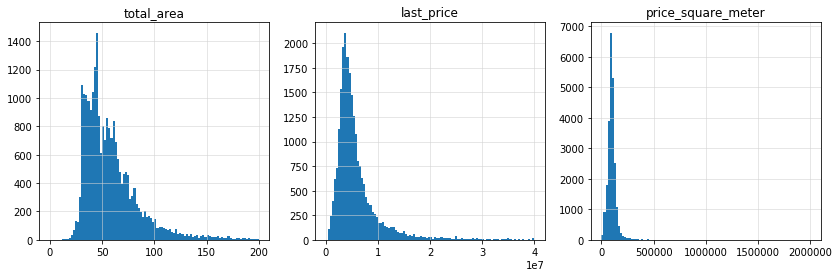

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

for item in ax:
    item.grid(color='lightgray', alpha=0.7)
    
ax[0].hist(df['total_area'], bins=100, range = (0, 200))   
ax[0].axes.set_title('total_area')

ax[1].hist(df['last_price'], bins=100, range = (0, 40000000))   
ax[1].axes.set_title('last_price')

ax[2].hist(df['price_square_meter'], bins=100, range = (0, 2000000))   
ax[2].axes.set_title('price_square_meter');


Сразу бросается в глаза аномальные величины минимальных и максимальных значений.   

Так минимальная величина общей площади квартиры равна $12 m^2$.  
А максимальная - $900 m^2$ !!!

Рассмотрим поподробнее.

In [40]:
pd.set_option('display.max_columns', None)
df.query('total_area <= 15').sort_values('total_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kind,rooms_group,kitchen_exist,locname_norm,price_square_meter,posting_week_day,posting_month,posting_year,floor_group,living_part,kitchen_part
19904,4,2400000.0,12.0,2017-07-19,1,2.55,5,10.000000,2,False,False,False,2.732579,0.0,Санкт-Петербург,21314.0,964.0,1.0,886.0,2.0,45.0,200.0,usual,1,False,Санкт-Петербург,200000.000000,3,7,2017,другой,0.833333,0.227715
17961,3,1400000.0,13.0,2017-12-03,1,2.60,9,6.175932,1,False,False,False,2.960294,0.0,Санкт-Петербург,14350.0,15945.0,0.0,NaN,1.0,185.0,410.0,usual,1,False,Санкт-Петербург,107692.307692,7,12,2017,первый,0.475072,0.227715
19546,3,1850000.0,13.0,2019-03-11,1,3.40,5,6.175932,2,False,False,False,2.960294,0.0,Санкт-Петербург,24915.0,5483.0,1.0,644.0,0.0,NaN,24.0,usual,1,False,Санкт-Петербург,142307.692308,1,3,2019,другой,0.475072,0.227715
19807,0,3800000.0,13.0,2018-07-04,1,2.65,5,10.000000,3,False,False,False,2.960294,0.0,Санкт-Петербург,21302.0,1242.0,1.0,592.0,3.0,27.0,9.0,usual,1,False,Санкт-Петербург,292307.692308,3,7,2018,другой,0.769231,0.227715
19558,2,1686000.0,13.2,2018-12-17,1,2.65,5,6.270946,1,False,False,False,3.005837,0.0,Санкт-Петербург,19891.0,4165.0,1.0,361.0,1.0,155.0,19.0,usual,1,False,Санкт-Петербург,127727.272727,1,12,2018,первый,0.475072,0.227715
19642,5,1190000.0,14.0,2018-07-29,1,2.65,5,11.000000,1,False,False,False,2.000000,0.0,Санкт-Петербург,9898.0,11122.0,0.0,NaN,0.0,NaN,4.0,usual,1,True,Санкт-Петербург,85000.000000,7,7,2018,первый,0.785714,0.142857
12040,5,1900000.0,15.0,2018-06-27,1,2.50,5,7.126075,1,False,False,False,3.415724,0.0,Сосновый Бор,NaN,NaN,NaN,NaN,NaN,NaN,45.0,usual,1,False,Сосновый Бор,126666.666667,3,6,2018,первый,0.475072,0.227715
16949,9,1550000.0,15.0,2018-08-21,1,2.70,9,7.126075,1,False,False,False,3.415724,0.0,Санкт-Петербург,51048.0,16376.0,0.0,NaN,1.0,1079.0,42.0,usual,1,False,Санкт-Петербург,103333.333333,2,8,2018,первый,0.475072,0.227715


In [41]:
df.query('total_area >= 500').sort_values('total_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kind,rooms_group,kitchen_exist,locname_norm,price_square_meter,posting_week_day,posting_month,posting_year,floor_group,living_part,kitchen_part
5893,3,230000000.0,500.0,2017-05-31,6,2.65,7,324.960762,7,False,False,False,40.000000,0.0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,50.0,usual,6,True,Санкт-Петербург,460000.000000,3,5,2017,последний,0.649922,0.080000
15016,8,150000000.0,500.0,2016-01-13,4,3.20,7,311.229200,7,False,False,False,58.161673,0.0,Санкт-Петербург,33058.0,6150.0,3.0,209.0,3.0,531.0,303.0,usual,4,False,Санкт-Петербург,300000.000000,3,1,2016,последний,0.622458,0.116323
8018,20,84000000.0,507.0,2015-12-17,5,4.45,7,301.500000,7,True,False,False,45.500000,1.0,Санкт-Петербург,NaN,5735.0,2.0,110.0,0.0,NaN,1078.0,usual,5,True,Санкт-Петербург,165680.473373,4,12,2015,последний,0.594675,0.089744
4237,1,50000000.0,517.0,2017-10-14,7,2.65,4,332.000000,3,False,False,False,22.000000,0.0,Санкт-Петербург,22835.0,1847.0,2.0,477.0,2.0,540.0,NaN,usual,7,True,Санкт-Петербург,96711.798839,6,10,2017,другой,0.642166,0.042553
5358,20,65000000.0,590.0,2019-02-14,15,3.50,6,409.000000,3,False,False,False,100.000000,0.0,Санкт-Петербург,24447.0,4666.0,1.0,767.0,0.0,NaN,14.0,usual,7,True,Санкт-Петербург,110169.491525,4,2,2019,другой,0.693220,0.169492
15651,20,300000000.0,618.0,2017-12-18,7,3.40,7,258.000000,5,False,False,False,70.000000,0.0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,111.0,usual,7,True,Санкт-Петербург,485436.893204,1,12,2017,другой,0.417476,0.113269
3117,19,140000000.0,631.0,2019-03-30,7,2.65,5,393.515361,5,False,False,False,60.000000,0.0,Санкт-Петербург,25707.0,4972.0,0.0,NaN,2.0,210.0,NaN,usual,7,True,Санкт-Петербург,221870.047544,6,3,2019,последний,0.623638,0.095087
12859,20,140000000.0,631.2,2019-04-09,7,3.90,4,322.300000,4,False,False,False,19.500000,1.0,Санкт-Петербург,25707.0,4972.0,0.0,NaN,2.0,210.0,NaN,usual,7,True,Санкт-Петербург,221799.746515,2,4,2019,последний,0.510615,0.030894
19540,8,420000000.0,900.0,2017-12-06,12,2.80,25,409.700000,25,False,False,False,112.000000,0.0,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0,usual,7,True,Санкт-Петербург,466666.666667,3,12,2017,последний,0.455222,0.124444


Судя по всему, это реальные квартиры, без опечаток и других ошибочных действий.  

Даже квартира с площадью 900 кв.м.выглядит реальной: занимает последний этаж нового дома, сравнительно недалеко от центра, рядом 2 водоема и вполне реальная цена за квадратный метр для такой квартиры... 
Но, поскольку эта квартира относится к выбивающимся значениям, то в дальнейшем из анализа мы ее уберем.

Что вызывает сомнения, так это максимальное значение цены продажи и цена за квадратный метр.  

Рассмотрим записи с не реально большими значениями.  
Как ранее говорилось, сейчас на рынке недвижимости Санкт-Петербурга можно встретить квартиру по 491 т.руб. за кв.метр.  
Допустим - ранее были квартиры еще ближе к центру и дороже. Будем считать, что аномальным выглядят квартиры с ценой от 600 т.руб. за кв.метр.

In [42]:
df_no_real = df.query('price_square_meter > 600000').sort_values('price_square_meter')
print('Всего:', df_no_real.__len__())
df_no_real.tail()

Всего: 21


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kind,rooms_group,kitchen_exist,locname_norm,price_square_meter,posting_week_day,posting_month,posting_year,floor_group,living_part,kitchen_part
4996,20,124000000.0,124.5,2017-10-12,4,3.00,4,67.2,2,False,False,False,20.000000,0.0,Санкт-Петербург,20399.0,1722.0,3.0,302.0,3.0,172.0,45.0,usual,4,True,Санкт-Петербург,9.959839e+05,4,10,2017,другой,0.539759,0.160643
14706,15,401300000.0,401.0,2016-02-20,5,2.65,9,204.0,9,False,False,False,24.000000,3.0,Санкт-Петербург,21912.0,2389.0,1.0,545.0,1.0,478.0,393.0,usual,5,True,Санкт-Петербург,1.000748e+06,6,2,2016,последний,0.508728,0.059850
22831,18,289238400.0,187.5,2019-03-19,2,3.37,6,63.7,6,False,False,False,30.200000,0.0,Санкт-Петербург,22494.0,1073.0,3.0,386.0,3.0,188.0,NaN,usual,2,True,Санкт-Петербург,1.542605e+06,2,3,2019,последний,0.339733,0.161067
1436,19,330000000.0,190.0,2018-04-04,3,3.50,7,95.0,5,False,False,False,40.000000,0.0,Санкт-Петербург,23011.0,1197.0,3.0,519.0,3.0,285.0,233.0,usual,3,True,Санкт-Петербург,1.736842e+06,3,4,2018,другой,0.500000,0.210526
12971,19,763000000.0,400.0,2017-09-30,7,2.65,10,250.0,10,False,False,False,30.775357,2.0,Санкт-Петербург,25108.0,3956.0,1.0,530.0,3.0,756.0,33.0,usual,7,False,Санкт-Петербург,1.907500e+06,6,9,2017,последний,0.625000,0.076938


Для примера, одно комнатная квартира площадью 33 $м^2$  стоит 28 млн.руб. или 850 т.руб.за $м^2$ !

Если квартиру с площадью 900 $m^2$ мы уже обсудили и все цифры по ней отнесли к реальным, то во всех остальных квартирах из списка сложно понять - это опечатка в `last_price`, из-за чего получаются не реально большие цены за квадратный метр, или реальные цены, по которым квартиры были проданы...  

Предлагаю убрать такие квартиры из дальнейшего анализа.

In [43]:
df = df.query('total_area != 900')
df = df[~df.index.isin(df_no_real.index)]
df['price_square_meter'].sort_values(ascending=False).head()

22869    600000.000000
12916    590694.239291
10011    588888.888889
13749    585365.853659
11430    583390.528483
Name: price_square_meter, dtype: float64

#### Изучение следующих параметров: число комнат, высота потолков.

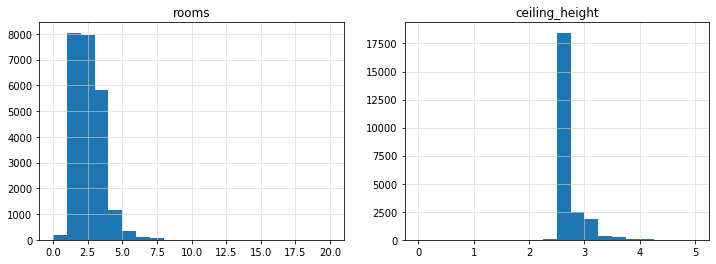

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for item in ax:
    item.grid(color='lightgray', alpha=0.7)
ax[0].hist(df['rooms'], bins=20, range = (0, 20))   
ax[0].axes.set_title('rooms')

ax[1].hist(df['ceiling_height'], bins=20, range = (0, 5))   
ax[1].axes.set_title('ceiling_height');

In [45]:
describes2 = df['rooms'].describe().to_frame()
describes2['ceiling_height'] = df['ceiling_height'].describe()

describes2

,rooms,ceiling_height
count,23677.000000,23677.000000
mean,2.068970,2.723914
std,1.074682,0.988386
min,0.000000,1.000000
25%,1.000000,2.600000
50%,2.000000,2.650000
75%,3.000000,2.700000
max,19.000000,100.000000


Хочу заметить, что ранее мы делали предобработку данных и всем квартирам-студиям присвоили значение 0 в поле rooms.  

Число 19 тоже выглядит реально, т.к. указано для квартиры площадью 375 кв.м.  

А вот данные по высоте потолков выглядят не реально.  
По всем нормативам, минимальная высота не должна быть менее 2.1 м.  
В сталинках высота может достигать 3.6 м., а в домах царских времен может достигать значений чуть более 4 м. В домах, переделанных из бывших мануфактур, потолки могут быть выше 5 м., но эти случаи крайне редки. Т.о. будем считать 5 м. и более - это аномально.  

Рассмотрим подробнее аномальные значения.

In [46]:
df.query('ceiling_height < 2').sort_values('ceiling_height')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kind,rooms_group,kitchen_exist,locname_norm,price_square_meter,posting_week_day,posting_month,posting_year,floor_group,living_part,kitchen_part
22590,16,6000000.0,55.0,2018-10-31,2,1.00,12,32.4,7,False,False,False,10.00,0.0,Санкт-Петербург,33053.0,14217.0,2.0,293.0,2.0,289.0,13.0,usual,2,True,Санкт-Петербург,109090.909091,3,10,2018,другой,0.589091,0.181818
5712,5,1500000.0,42.8,2017-08-14,2,1.20,2,27.5,1,False,False,False,5.20,0.0,городской посёлок Мга,NaN,NaN,NaN,NaN,NaN,NaN,248.0,usual,2,True,городской поселок Мга,35046.728972,1,8,2017,первый,0.642523,0.121495
16934,5,4100000.0,40.0,2017-10-17,1,1.75,37,17.4,5,False,False,False,8.34,0.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,71.0,usual,1,True,Санкт-Петербург,102500.000000,2,10,2017,другой,0.435000,0.208500


Очевидно, что эти значения введены с ошибками. Вероятнее всего, первая цифра должна быть 2.  
Но мы просто заменим их на медиану.

In [47]:
too_high = df[df['ceiling_height'] >= 5]['ceiling_height']

too_high.count()

36

In [48]:
too_high.unique()

array([ 25. ,   5.2,   5.3,   5. ,   5.6,  32. ,   8. ,  27. ,  24. ,
        26. ,   8.3,   5.5,  14. ,  20. ,  22.6,   5.8,  27.5,  10.3,
       100. ])

Хочу отметить, что я отдельно проверил все эти квартиры с аномальными значениями. Все они расположены в многоэтажных домах, а значит сделаны по каким-то стандартам с реалистичными размерами потолков.  

Перечисленные в массиве значения такими не являются.  

Можно предположить, что в значениях от 20 до 32 не верно указали запятую после целого числа. Поэтому эти значения мы поделим на 10.  

Вместо остальных применим медианы.

In [49]:
def change_ceiling_height(row):
    ceiling_height = row['ceiling_height']
    if 20 <= ceiling_height <= 32:
        return float(ceiling_height / 10)
    if ceiling_height < 2 or 5 <= ceiling_height:
        return 2.65
    return ceiling_height

df['ceiling_height'] = df.apply(change_ceiling_height, axis = 1)
df['ceiling_height'].describe()

count    23677.000000
mean         2.695583
std          0.214539
min          2.000000
25%          2.600000
50%          2.650000
75%          2.700000
max          4.900000
Name: ceiling_height, dtype: float64

#### Изучение days_exposition — сколько дней было размещено объявление (от публикации до снятия)

Всего пропусков 3181 шт.

In [50]:
df.query('days_exposition.isna()').pivot_table(index='posting_year', values='total_area', aggfunc='count')

,total_area
posting_year,
2014,18
2015,70
2016,67
2017,270
2018,959
2019,1792


Очевидно, что пропуски означают только то, что объявления до сих пор размещены и квартиры еще не проданы.

In [51]:
print(df['days_exposition'].describe())

count    20501.000000
mean       180.810936
std        219.694118
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64


/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


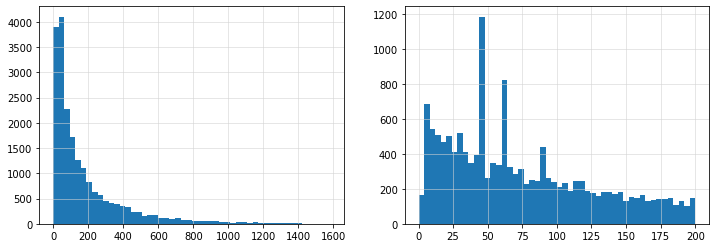

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for item in ax:
    item.grid(color='lightgray', alpha=0.7)
ax[0].hist(df['days_exposition'], bins=50)   

ax[1].hist(df['days_exposition'], bins=50, range = (0, 200));

Сроки продаж квартир очень разбросаны и в среднем занимают 180 дней.  
Половина всех продаж приходится на первые 95 дней, а четверть продаж приходится на первые 45 дней.  

В общем-то, этот срок (45 дней) и можно считать за срок очень быстрой продажи.  
А очень долгий срок - это когда квартира не была продана за год (360 дней).

### price_square_meter - цена за квадратный метр.

Зависит ли цена от площади квартиры, числа комнат, этажа (первого или последнего), удалённости от центра, от даты размещения: дня недели, месяца и года?

Берем в рассмотрение проданные квартиры, т.е. те, у которых поле days_exposition заполнено.

In [53]:
df_red = df.query('~days_exposition.isna()').loc[:, ['price_square_meter', 'total_area', 'rooms', 'cityCenters_nearest', 'posting_month', 'posting_year', 'floor_group']]
ch = {'первый': 1, 'другой': 2, 'последний': 3}
df_red['floor_group_num'] = df_red['floor_group'].apply(lambda x: ch.get(x))
df_red.query('total_area > 400').sort_values('total_area').tail()

,price_square_meter,total_area,rooms,cityCenters_nearest,posting_month,posting_year,floor_group,floor_group_num
5893,460000.000000,500.0,6,5297.0,5,2017,последний,3
15016,300000.000000,500.0,4,6150.0,1,2016,последний,3
8018,165680.473373,507.0,5,5735.0,12,2015,последний,3
5358,110169.491525,590.0,15,4666.0,2,2019,другой,2
15651,485436.893204,618.0,7,5297.0,12,2017,другой,2


In [54]:
df_red.corr()

,price_square_meter,total_area,rooms,cityCenters_nearest,posting_month,posting_year,floor_group_num
price_square_meter,1.000000,0.275867,0.025376,-0.371200,0.006394,-0.007588,0.050184
total_area,0.275867,1.000000,0.762266,-0.235773,0.002591,-0.114023,0.060483
rooms,0.025376,0.762266,1.000000,-0.193786,-0.002898,-0.096574,0.022426
cityCenters_nearest,-0.371200,-0.235773,-0.193786,1.000000,-0.010996,0.049529,-0.024710
posting_month,0.006394,0.002591,-0.002898,-0.010996,1.000000,-0.196905,0.010475
posting_year,-0.007588,-0.114023,-0.096574,0.049529,-0.196905,1.000000,0.001807
floor_group_num,0.050184,0.060483,0.022426,-0.024710,0.010475,0.001807,1.000000


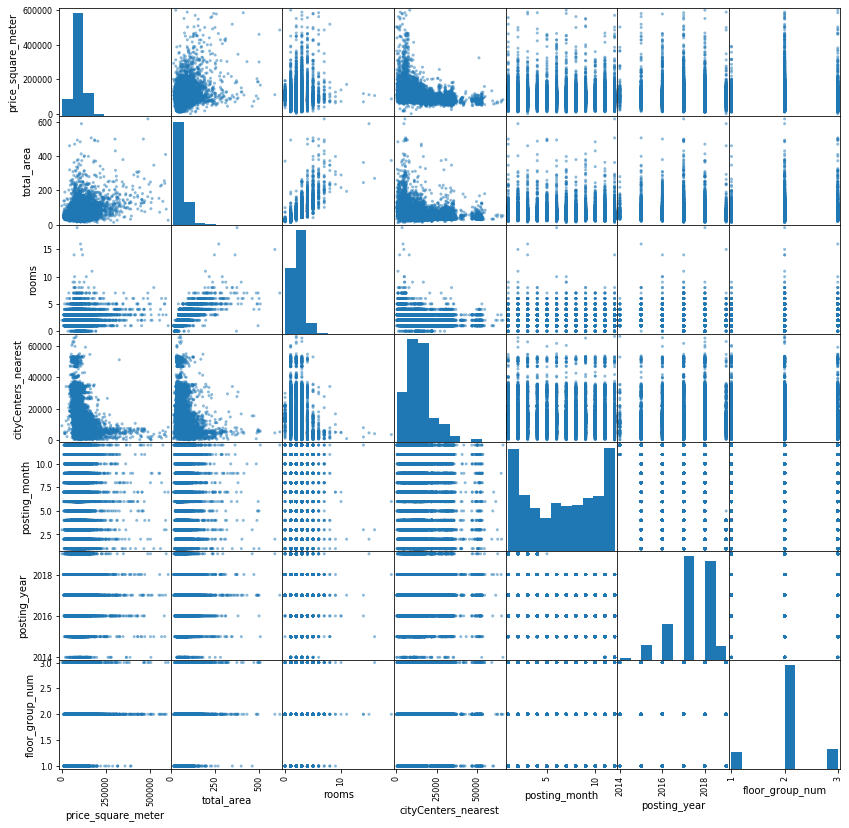

In [55]:
pd.plotting.scatter_matrix(df_red, figsize=(14, 14));

Наблюдается зависимость цены за квадратный метр от количества комнат (наибольшие цены приходятся на 3-х комнатные), некая зависимость от общей площади (наибольшие цены приходятся на квартиры площадью до 150 кв.м.),  обратная зависимость от удаленности от центра (чем дальше, тем меньше) и небольшая зависимость от этажа (наименьшие цены у квартир на первом этаже, затем - на последнем, а наибольшие - на прочих этажах).

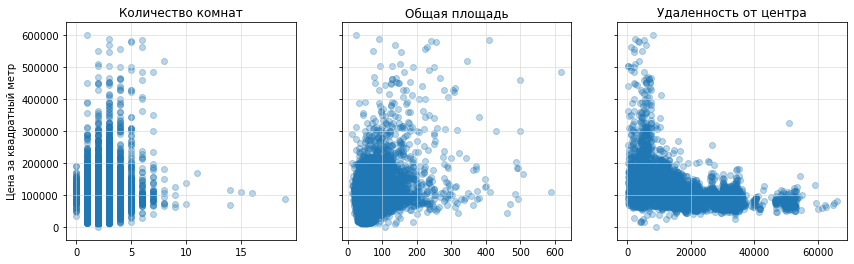

In [56]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4), sharey=True)
for item in ax:
    item.grid(color='lightgray', alpha=0.7)
ax[0].scatter(x=df_red['rooms'], y=df_red['price_square_meter'], alpha=0.3)
ax[0].set_title('Количество комнат')
ax[0].set_ylabel('Цена за квадратный метр')

ax[1].scatter(x=df_red['total_area'], y=df_red['price_square_meter'], alpha=0.3)
ax[1].set_title('Общая площадь')

ax[2].scatter(x=df_red['cityCenters_nearest'], y=df_red['price_square_meter'], alpha=0.3)
ax[2].set_title('Удаленность от центра');

#### Изучение зависимости от даты размещения: дня недели, месяца и года.

In [57]:
import datetime
df_red2 = df_red.loc[:, ['price_square_meter', 'week_day', 'posting_month', 'posting_year']]
df_red2['days_exposition'] = df['days_exposition']
df_red2['year_of_sale'] = pd.to_numeric((
    (df['first_day_exposition'] + pd.to_timedelta(df['days_exposition'], unit='d')).dt.year
), errors="coerce", downcast='integer')
# df_red2['year_of_sale'] = df_red2['year_of_sale'].astype('int')
df_red2.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,price_square_meter,week_day,posting_month,posting_year,days_exposition,year_of_sale
1,82920.792079,NaN,12,2018,81.0,2019.0
2,92785.714286,NaN,8,2015,558.0,2017.0
3,408176.100629,NaN,7,2015,424.0,2016.0
4,100000.000000,NaN,6,2018,121.0,2018.0
5,95065.789474,NaN,9,2018,55.0,2018.0


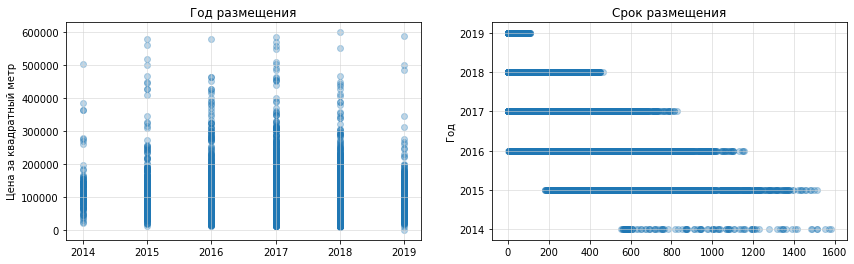

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
for item in ax:
    item.grid(color='lightgray', alpha=0.7)
ax[0].scatter(x=df_red2['posting_year'], y=df_red2['price_square_meter'], alpha=0.3)
ax[0].set_title('Год размещения')
ax[0].set_ylabel('Цена за квадратный метр')

ax[1].scatter(x=df_red2['days_exposition'], y=df_red2['posting_year'], alpha=0.3)
ax[1].set_title('Срок размещения')
ax[1].set_ylabel('Год');

In [59]:
df_red2_pt = df_red2.pivot_table(index='posting_year', columns='year_of_sale', 
                                 values='price_square_meter', aggfunc='count', fill_value='0')
df_red2_pt.columns = ['2016', '2017', '2018', '2019']
df_red2_pt['2016'] = df_red2_pt['2016'].astype('int')
df_red2_pt['2017'] = df_red2_pt['2017'].astype('int')
df_red2_pt['2018'] = df_red2_pt['2018'].astype('int')
df_red2_pt['sum'] = df_red2_pt.loc[:,:].sum(axis=1)
df_red2_pt.head()

,2016,2017,2018,2019,sum
posting_year,,,,,
2014,46,43,23,7.0,119.0
2015,501,355,223,40.0,1119.0
2016,1328,792,524,70.0,2714.0
2017,0,3919,3722,268.0,7909.0
2018,0,0,6056,1501.0,7557.0


Выше приведенная таблица показывает сколько было продано квартир по годам из тех, которые были заявлены в соответствующем году.  

Наблюдается некая зависимость от года размещения объявления.  

Как видно из таблицы, наибольшее число квартир было продано по объявлениям, размещенных в 2017 г.   

Из графика видно, что и цены по квартирам, объявленных в 2017 г., были выше.  

Какой-либо зависимости от дня недели размещения объявления не наблюдается.

#### Изучение населенных пунктов

In [60]:
ln_pivot_table = df.pivot_table(index='locname_norm', values='price_square_meter', aggfunc=['count', 'mean'])
ln_pivot_table.set_axis(['count', 'mean'], axis='columns', inplace=True)
ln_pivot_table.sort_values(by='count', ascending=False, inplace=True)

ln_max = ln_pivot_table.query('mean == mean.max()')
for k, v in ln_max.to_dict()['mean'].items():
    print('Самая высокая стоимость жилья в {} - {:,.2f} р.за кв.м.'.format(k, v))
    
ln_min = ln_pivot_table.query('mean == mean.min()')
for k, v in ln_min.to_dict()['mean'].items():
    print('Самая низкая стоимость жилья в {} - {:,.2f} р.за кв.м.'.format(k, v))

ln_pivot_table.head(10)


Самая высокая стоимость жилья в Зеленогорск - 115,122.80 р.за кв.м.
Самая низкая стоимость жилья в деревня Старополье - 11,206.22 р.за кв.м.


,count,mean
locname_norm,,
Санкт-Петербург,15700,113825.953220
поселок Мурино,556,85681.762601
поселок Шушары,440,78677.364217
Всеволожск,397,67214.252635
Пушкин,369,103125.819291
Колпино,338,75424.579098
поселок Парголово,327,90175.913458
Гатчина,307,68746.146763
деревня Кудрово,299,92473.547576


#### Предложения квартир в Санкт-Петербурге

In [61]:
df_red3 = df.loc[:, ['price_square_meter', 'locality_name', 'cityCenters_nearest']]
df_red3 = df_red3.query('(locality_name == "Санкт-Петербург") & (~cityCenters_nearest.isna())')
df_red3['cityCenters_nearest'] = df['cityCenters_nearest'].round()
df_red3.cityCenters_nearest = df_red3.cityCenters_nearest.astype('int')

df_red3.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15639 entries, 0 to 23697
Data columns (total 3 columns):
price_square_meter     15639 non-null float64
locality_name          15639 non-null object
cityCenters_nearest    15639 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 488.7+ KB


In [62]:
distance_grouped = df_red3.groupby('cityCenters_nearest').mean()


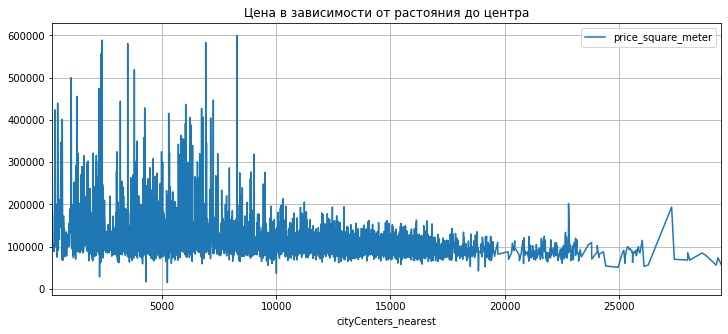

In [63]:
distance_grouped.plot(title='Цена в зависимости от растояния до центра', grid=True, figsize=(12, 5));

Как видно из графика, очень большой разброс наблюдается почти до 10 000 м. от центра города.  
Поэтому с большой уверенностью можно сказать, что центральная зона города находится в пределах 10 км.

In [64]:
central_zone = df.query('(cityCenters_nearest <= 10000) & (locality_name == "Санкт-Петербург")')
central_zone = central_zone.loc[:, ['price_square_meter', 'total_area','first_day_exposition','rooms','ceiling_height', 'cityCenters_nearest']]
central_zone['price_square_meter'] = central_zone['price_square_meter'].round(2)
ch = {'первый': 1, 'другой': 2, 'последний': 3}
central_zone['floor_group_num'] = df['floor_group'].apply(lambda x: ch.get(x)).astype('int')
central_zone.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5051 entries, 3 to 23694
Data columns (total 7 columns):
price_square_meter      5051 non-null float64
total_area              5051 non-null float64
first_day_exposition    5051 non-null datetime64[ns]
rooms                   5051 non-null int64
ceiling_height          5051 non-null float64
cityCenters_nearest     5051 non-null float64
floor_group_num         5051 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 315.7 KB


In [65]:
central_zone.head()

,price_square_meter,total_area,first_day_exposition,rooms,ceiling_height,cityCenters_nearest,floor_group_num
3,408176.10,159.0,2015-07-24,3,2.65,6800.0,2
4,100000.00,100.0,2018-06-19,2,3.03,8098.0,2
21,101265.82,31.6,2018-03-14,1,2.65,9722.0,2
24,66872.43,97.2,2015-10-31,2,2.65,2336.0,1
35,104026.85,149.0,2017-06-26,5,2.65,3502.0,2


In [66]:
describes3 = central_zone['price_square_meter'].describe().to_frame()
describes3['total_area'] = central_zone['total_area'].describe()
describes3['rooms'] = central_zone['rooms'].describe()
describes3['ceiling_height'] = central_zone['ceiling_height'].describe()
describes3['floor_group_num'] = central_zone['floor_group_num'].describe()

describes3 = describes3.round(2)
describes3

,price_square_meter,total_area,rooms,ceiling_height,floor_group_num
count,5051.00,5051.00,5051.00,5051.00,5051.00
mean,133489.46,83.79,2.62,2.87,2.06
std,61472.73,54.11,1.38,0.33,0.52
min,111.83,12.00,0.00,2.00,1.00
25%,98037.46,49.00,2.00,2.65,2.00
50%,118364.42,70.90,2.00,2.70,2.00
75%,146449.58,99.35,3.00,3.00,2.00
max,600000.00,631.20,19.00,4.90,3.00


In [67]:
central_zone.corr()

,price_square_meter,total_area,rooms,ceiling_height,cityCenters_nearest,floor_group_num
price_square_meter,1.000000,0.249223,0.003393,0.119396,-0.140473,0.042456
total_area,0.249223,1.000000,0.757638,0.321569,-0.253998,0.126264
rooms,0.003393,0.757638,1.000000,0.288488,-0.277254,0.099700
ceiling_height,0.119396,0.321569,0.288488,1.000000,-0.339541,0.034343
cityCenters_nearest,-0.140473,-0.253998,-0.277254,-0.339541,1.000000,-0.024982
floor_group_num,0.042456,0.126264,0.099700,0.034343,-0.024982,1.000000


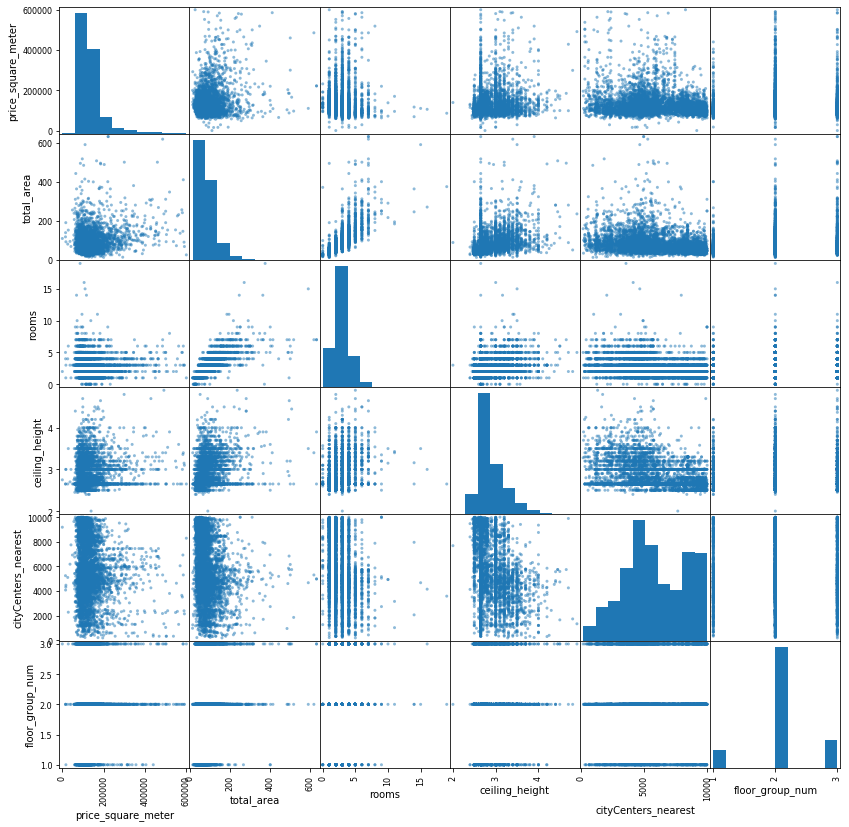

In [68]:
pd.plotting.scatter_matrix(central_zone, figsize=(14, 14));

Наблюдается зависимость цены квадратного метра от количества комнат (наибольшие цены приходятся на 3-х комнатные квартиры), некая зависимость от общей площади (наибольшие цены приходятся на квартиры площадью до 150 кв.м.) и некая зависимость от этажности (наименьшие цены у квартир на первом этаже, затем - на последнем, а наибольшие - на прочих этажах).

В целом выводы по центральной части города совпадают с выводами по всему городу.  

За исключением одного момента - в центальной части уже почти не играет значение удаленность от центра (в общем-то, это уже центральная часть).

Высота потолков тоже не особо влияет на стоимость квадратного метра.

### 5. Общий вывод

In [69]:
indx, col_info = info(df)
df_info2 = pd.DataFrame(data=col_info, index=indx, columns=['info2'])


In [70]:
df_info = df_info.merge(df_info2, left_index=True, right_index=True, how='outer')
df_info['isna2'] = df.isna().sum()
df_info


,info,isna,info2,isna2
airports_nearest,18157 non-null float64,5542.0,18717 non-null float64,4960
balcony,12180 non-null float64,11519.0,23677 non-null float64,0
ceiling_height,14504 non-null float64,9195.0,23677 non-null float64,0
cityCenters_nearest,18180 non-null float64,5519.0,18741 non-null float64,4936
days_exposition,20518 non-null float64,3181.0,20501 non-null float64,3176
first_day_exposition,23699 non-null object,0.0,23677 non-null datetime64[ns],0
floor,23699 non-null int64,0.0,23677 non-null int64,0
floor_group,NaN,NaN,23677 non-null object,0
floors_total,23613 non-null float64,86.0,23677 non-null int64,0
is_apartment,2775 non-null object,20924.0,23677 non-null bool,0


Как видно из сравнительной таблицы по информации в начале и в конце нашего исследования, была проведена большая работа по предобработке данных, добавлении новых столбцов для проведения необходимых рассчетов, нормализованы названия населенных пунктов (буква ё была заменена на букву е).  

Убраны редкие и выбивающиеся значения. Где это возможно были заполнены пропуски средними значениями или медианами.  
Был проведен анализ в целом по городу и отдельно для центральной его части.

Исследования показали, что выводы как в целом по городу, так и для центральной ее части не сильно различаются:
  - стоимость квадратного зависит от количества комнат - наибольшие цены приходятся на 3-х комнатные квартиры;
  - существует некая зависимость от общей площади (наибольшие цены приходятся на квартиры площадью до 150 кв.м.);
  - есть зависимость от этажности (наименьшие цены у квартир на первом этаже и на последнем этажах).

Различие существует только по расстоянию до центра города. Так для в центальной части уже почти не играет значение удаленность от центра, а в остальной части города эта зависимость существует.
